In [43]:
# Standard libraries
import datetime
import math
import pathlib
import re
import requests
import sqlite3
import sys

# Installed libraries
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd
import spiceypy
import tqdm

# Append to root directory of this repository
sys.path.append("../")

# Auxiliary module that contains the apparent magnitude
from auxiliary import photometry

In [5]:
# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

In [6]:

# Define the directory and name of the Granvik data. The data are originally stored as a gzip
# file and need to be unzipped
data_dir = pathlib.Path("raw_data/")
data_dir.mkdir(parents=True, exist_ok=True)
granvik_neo_model_file_zip = pathlib.Path("Granvik+_2018_Icarus.dat.gz")
granvik_neo_model_file = pathlib.Path("Granvik+_2018_Icarus.dat")

data_filepath = data_dir / granvik_neo_model_file
download_filepath = data_dir / granvik_neo_model_file_zip
print(f"Our Granvik et al. (2018) file path: {data_filepath}")

Our Granvik et al. (2018) file path: raw_data/Granvik+_2018_Icarus.dat


In [7]:
# Download the Granvik Model
dl_link = "https://www.mv.helsinki.fi" \
          "/home/mgranvik/data/Granvik+_2018_Icarus/Granvik+_2018_Icarus.dat.gz"
response = requests.get(dl_link)
download_file_path = pathlib.Path(download_filepath)
with download_file_path.open(mode="wb+") as file_obj:
    file_obj.write(response.content)

In [8]:
# We use the standard libraries gzip and shutil to unzip the file
import gzip
import shutil

with gzip.open(download_file_path, 'rb') as f_in:
    with open(data_filepath, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [9]:
granvik_model_df = pd.read_csv(data_filepath, names=["SemiMajorAxis_AU",
                                                     "Ecc_",
                                                     "Incl_deg",
                                                     "LongAscNode_deg",
                                                     "ArgP_deg",
                                                     "MeanAnom_deg",
                                                     "H"],
                               delim_whitespace=True)

/tmp/ipykernel_1328920/329592897.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  granvik_model_df = pd.read_csv(data_filepath, names=["SemiMajorAxis_AU",


In [10]:
granvik_model_df

,SemiMajorAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,MeanAnom_deg,H
0,2.574981,0.783617,33.520763,278.480591,75.952057,103.833748,21.064367
1,1.682046,0.275324,25.924536,169.683060,350.926636,46.401562,24.683197
2,2.480214,0.546448,14.240792,121.685623,316.509247,279.612305,24.843449
3,1.941440,0.620780,13.679822,8.245143,175.087372,129.364609,24.954794
4,1.114843,0.548071,37.906609,209.261627,37.110592,120.817390,24.342936
...,...,...,...,...,...,...,...
801995,2.877656,0.607120,6.684607,118.446182,39.764286,265.229523,23.330488
801996,1.563997,0.207188,28.263660,135.846954,82.046822,101.014885,24.990154
801997,2.679385,0.535874,7.462100,227.803268,272.786926,153.444550,23.996401
801998,1.592931,0.826241,43.307148,337.204224,43.215237,107.381775,24.795914


In [11]:
# Load SPICE kernels
spiceypy.furnsh("../kernels/spk/de440s.bsp")
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/pck/gm_de440.tpc")

# Get the G*M value of the Sun
_, gm_sun_pre = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
gm_sun = gm_sun_pre[0]

In [12]:
# Add the perihelion and convert the angular values to deg
granvik_model_df.loc[:, "Perihelion_AU"] = (1.0 - granvik_model_df["Ecc_"]) \
                                               * granvik_model_df["SemiMajorAxis_AU"]

granvik_model_df.loc[:, "Incl_rad"] = np.radians(granvik_model_df["Incl_deg"])
granvik_model_df.loc[:, "LongAscNode_rad"] = np.radians(granvik_model_df["LongAscNode_deg"])
granvik_model_df.loc[:, "ArgP_rad"] = np.radians(granvik_model_df["ArgP_deg"])

# Convert AU to km
granvik_model_df.loc[:, "Perihelion_km"] = \
    granvik_model_df["Perihelion_AU"].apply(lambda x: spiceypy.convrt(x, "AU", "km"))
granvik_model_df.loc[:, "SemiMajorAxis_km"] = \
    granvik_model_df["SemiMajorAxis_AU"].apply(lambda x: spiceypy.convrt(x, "AU", "km"))

In [13]:
# SPICE does not handle true anomalies so computing the mean later used as per paper
def true2mean(true_anom, ecc):

    atan2_x1 = -1.0 * np.sqrt(1.0 - ecc**2.0) * np.sin(true_anom)
    atan2_x2 = -1.0 * ecc - np.cos(true_anom)

    mean_anom = np.arctan2(atan2_x1, atan2_x2) \
                + np.pi \
                - ecc * ((np.sqrt(1.0 - ecc**2.0) * np.sin(true_anom))
                         / (1.0 + ecc * np.cos(true_anom)))

    return mean_anom

In [14]:
# Sample orbit per paper
sample_rp = spiceypy.convrt(0.5, "AU", "km")
sample_ecc = 0.7
sample_incl = 0.0
sample_lnode = 0.0
sample_argp = 0.0
sample_et = spiceypy.utc2et("2000-001T12:00:00")

In [15]:
# First we create a "complete" orbit that is used to explain our method:
mean_anomaly = np.radians(np.arange(0, 360, 0.1))

# List that will store the positions in 2D (X-Y plane)
sample_trajectory = []

for k in tqdm.tqdm(mean_anomaly):

    # Compute the state vector and store in positional values in X-Y direction, converted in AU
    temp_state = spiceypy.conics([sample_rp, sample_ecc, sample_incl, sample_lnode, sample_argp,
                                  k, sample_et, gm_sun], sample_et)
    sample_trajectory.append([spiceypy.convrt(temp_state[0], "km", "AU"),
                              spiceypy.convrt(temp_state[1], "km", "AU")])

sample_trajectory = np.array(sample_trajectory)

100%|██████████| 3600/3600 [00:00<00:00, 83978.92it/s]


In [16]:
# Now we create 36 NEO positions using the mean anomaly.
mean_anomaly = np.radians(np.arange(0, 360, 10))

# List that will store the positions in 2D (X-Y plane)
mean_anom_10deg_trajectory = []

for k in tqdm.tqdm(mean_anomaly):

    # Compute the state vector and store in positional values in X-Y direction, converted in AU
    temp_state = spiceypy.conics([sample_rp, sample_ecc, sample_incl, sample_lnode, sample_argp,
                                  k, sample_et, gm_sun], sample_et)
    mean_anom_10deg_trajectory.append([spiceypy.convrt(temp_state[0], "km", "AU"),
                                       spiceypy.convrt(temp_state[1], "km", "AU")])

mean_anom_10deg_trajectory = np.array(mean_anom_10deg_trajectory)

100%|██████████| 36/36 [00:00<00:00, 35519.86it/s]


In [17]:
# conversions

true_anomaly = np.radians(np.arange(0, 360, 10))
mean_from_true_anom = [true2mean(n, sample_ecc) for n in true_anomaly]

# List that will store the positions in 2D (X-Y plane)
true_anom_10deg_trajectory = []

for k in tqdm.tqdm(mean_from_true_anom):

    # Compute the state vector and store in positional values in X-Y direction, converted in AU
    temp_state = spiceypy.conics([sample_rp, sample_ecc, sample_incl, sample_lnode, sample_argp,
                                  k, sample_et, gm_sun], sample_et)
    true_anom_10deg_trajectory.append([spiceypy.convrt(temp_state[0], "km", "AU"),
                                       spiceypy.convrt(temp_state[1], "km", "AU")])

true_anom_10deg_trajectory = np.array(true_anom_10deg_trajectory)

100%|██████████| 36/36 [00:00<00:00, 47602.44it/s]


In [18]:
# First, let's add an epoch self defined because for unbiased model there's no time constraint
granvik_model_df.loc[:, "epoch_et"] = spiceypy.utc2et("2000-001T12:00:00")

In [19]:
# We remove the Mean Anomaly first and simplify to fit in 2D covering entire sky dumb down the model
granvik_model_df.drop(columns="MeanAnom_deg", inplace=True)

# replace it with an array
mean_anomaly_deg_array = np.arange(0, 360, 60)
granvik_model_df.loc[:, "MeanAnom_deg"] = [mean_anomaly_deg_array for i in granvik_model_df.index]

In [21]:
# Explode the list for data points
granvik_model_df = granvik_model_df.explode("MeanAnom_deg").copy()
granvik_model_df.loc[:, "MeanAnom_rad"] = \
    granvik_model_df["MeanAnom_deg"].apply(lambda x: np.radians(x))
granvik_model_df.reset_index(drop=True, inplace=True)

In [22]:
# Store the resulting dataframe parquet
data_dir = pathlib.Path("../databases/Granvik")
data_dir.mkdir(parents=True, exist_ok=True)
dataframe_filepath = data_dir / "enriched_granvik_model.parquet"

In [23]:
granvik_model_df.to_parquet(dataframe_filepath)

In [ ]:
# Load the model

In [24]:
# Load the Granvik model
data_dir = pathlib.Path("../databases/Granvik")
data_dir.mkdir(parents=True, exist_ok=True)
dataframe_filepath = data_dir / "enriched_granvik_model.parquet"

granvik_model_df = pd.read_parquet(dataframe_filepath)

In [25]:
granvik_model_df

,SemiMajorAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,H,Perihelion_AU,Incl_rad,LongAscNode_rad,ArgP_rad,Perihelion_km,SemiMajorAxis_km,epoch_et,MeanAnom_deg,MeanAnom_rad
0,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,8.335328e+07,3.852117e+08,64.183927,0,0.000000
1,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,8.335328e+07,3.852117e+08,64.183927,60,1.047198
2,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,8.335328e+07,3.852117e+08,64.183927,120,2.094395
3,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,8.335328e+07,3.852117e+08,64.183927,180,3.141593
4,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,8.335328e+07,3.852117e+08,64.183927,240,4.188790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4811995,2.591117,0.826896,22.001493,334.001678,286.224030,24.542505,0.448532,0.383999,5.829429,4.995552,6.709938e+07,3.876256e+08,64.183927,60,1.047198
4811996,2.591117,0.826896,22.001493,334.001678,286.224030,24.542505,0.448532,0.383999,5.829429,4.995552,6.709938e+07,3.876256e+08,64.183927,120,2.094395
4811997,2.591117,0.826896,22.001493,334.001678,286.224030,24.542505,0.448532,0.383999,5.829429,4.995552,6.709938e+07,3.876256e+08,64.183927,180,3.141593
4811998,2.591117,0.826896,22.001493,334.001678,286.224030,24.542505,0.448532,0.383999,5.829429,4.995552,6.709938e+07,3.876256e+08,64.183927,240,4.188790


In [26]:
#Get the Epoch in ET to compute the state vectors of ...
init_et = granvik_model_df.iloc[0]["epoch_et"]

# ... the Earth as seen from the Sun
sun2earth_position_vec = spiceypy.spkgps(targ=399,
                                         et=init_et,
                                         ref="ECLIPJ2000",
                                         obs=10)[0]

# Invert the Sun -> Earth vector to get the Earth -> Sun vector
earth2sun_position_vec = -1.0 * sun2earth_position_vec

In [27]:
# computing apparent magnitude
tqdm.tqdm.pandas()


# position vector of NEO as seen from sun
granvik_model_df.loc[:, "sun2neo_position_vec"] = \
    granvik_model_df.progress_apply(lambda x: spiceypy.conics(elts=[x["Perihelion_km"],
                                                                    x["Ecc_"],
                                                                    x["Incl_rad"],
                                                                    x["LongAscNode_rad"],
                                                                    x["ArgP_rad"],
                                                                    x["MeanAnom_rad"],
                                                                    x["epoch_et"],
                                                                    gm_sun],
                                                            et=init_et)[:3],
                                    axis=1)

100%|██████████| 4812000/4812000 [01:29<00:00, 53829.15it/s]


In [29]:
# cleaning for mag
granvik_model_df.loc[:, "neo2earth_position_vec"] = \
    granvik_model_df["sun2neo_position_vec"].progress_apply(lambda x: sun2earth_position_vec - x)
granvik_model_df.loc[:, "neo2sun_position_vec"] = \
    granvik_model_df["sun2neo_position_vec"].progress_apply(lambda x: -1.0 * x)

granvik_model_df.loc[:, "neo2earth_position_vec_AU"] = \
    granvik_model_df["neo2earth_position_vec"].progress_apply(lambda x: [spiceypy.convrt(k, "km", "AU") for k in x])
granvik_model_df.loc[:, "neo2sun_position_vec_AU"] = \
    granvik_model_df["neo2sun_position_vec"].progress_apply(lambda x: [spiceypy.convrt(k, "km", "AU") for k in x])

100%|██████████| 4812000/4812000 [00:47<00:00, 101467.25it/s]


In [30]:
# Compute the apparent magnitude of each NEO (for the set epoch)
granvik_model_df.loc[:, "app_mag"] = \
    granvik_model_df.progress_apply(lambda x:
                                    photometry.hg_app_mag(abs_mag=x["H"],
                                                          vec_obj2obs=x["neo2earth_position_vec_AU"],
                                                          vec_obj2ill=x["neo2sun_position_vec_AU"],
                                                          slope_g=0.15),
                                    axis=1)

100%|██████████| 4812000/4812000 [01:21<00:00, 58766.86it/s]


In [31]:
# more conversions
granvik_model_df.loc[:, "earth2neo_position_vec_AU"] = \
    granvik_model_df["neo2earth_position_vec_AU"].progress_apply(lambda x: -1.0 * np.array(x))

granvik_model_df.loc[:, "earth2neo_recrad"] = \
    granvik_model_df["earth2neo_position_vec_AU"].progress_apply(lambda x: spiceypy.recrad(x))

granvik_model_df.loc[:, "earth2neo_dist_AU"] = \
    granvik_model_df["earth2neo_recrad"].progress_apply(lambda x: x[0])

granvik_model_df.loc[:, "earth2neo_eclip_long"] = \
    granvik_model_df["earth2neo_recrad"].progress_apply(lambda x: x[1])

granvik_model_df.loc[:, "earth2neo_eclip_lat"] = \
    granvik_model_df["earth2neo_recrad"].progress_apply(lambda x: x[2])

100%|██████████| 4812000/4812000 [00:02<00:00, 2225648.02it/s]


In [32]:
# angular distance between seen from Earth
granvik_model_df.loc[:, "ang_dist_neo2sun_deg"] = \
    granvik_model_df["earth2neo_position_vec_AU"] \
        .progress_apply(lambda x: np.degrees(spiceypy.vsep(x, earth2sun_position_vec)))

100%|██████████| 4812000/4812000 [01:01<00:00, 78421.62it/s]


In [33]:
# cleaning
granvik_model_df.drop(columns=["neo2earth_position_vec",
                               "neo2sun_position_vec",
                               "neo2earth_position_vec_AU",
                               "neo2sun_position_vec_AU",
                               "earth2neo_position_vec_AU",
                               "earth2neo_recrad"],
                      inplace=True)

In [34]:
# df as parquet file
dataframe_filepath = data_dir / "enriched_granvik_model_w_appmag.parquet"

granvik_model_df.to_parquet(dataframe_filepath)

In [35]:
granvik_model_df[:5]

,SemiMajorAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,H,Perihelion_AU,Incl_rad,LongAscNode_rad,ArgP_rad,...,SemiMajorAxis_km,epoch_et,MeanAnom_deg,MeanAnom_rad,sun2neo_position_vec,app_mag,earth2neo_dist_AU,earth2neo_eclip_long,earth2neo_eclip_lat,ang_dist_neo2sun_deg
0,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,...,3.852117e+08,64.183927,0,0.000000,"[69658892.50602701, -10069855.30884874, 446542...",22.119561,1.254025,5.268338,0.240340,25.333703
1,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,...,3.852117e+08,64.183927,60,1.047198,"[-314866378.53349483, 277522650.6289163, -1791...",26.295329,2.436915,2.709946,-0.513805,120.058832
2,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,...,3.852117e+08,64.183927,120,2.094395,"[-509690285.6128618, 209044829.52714097, -3135...",27.900894,3.874181,3.009198,-0.571548,105.034810
3,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,...,3.852117e+08,64.183927,180,3.141593,"[-574189095.8208486, 83004493.85316256, -36807...",28.344639,4.430274,3.253761,-0.588812,93.285636
4,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,...,3.852117e+08,64.183927,240,4.188790,"[-525182862.08193463, -59444075.26023075, -349...",28.134247,4.294702,3.530143,-0.575900,80.054676


In [36]:
# matplotlib map projection (data engineering)
granvik_model_df.loc[:, "earth2neo_eclip_long_4plot"] = \
    granvik_model_df["earth2neo_eclip_long"].apply(lambda x: -1*((x % np.pi) - np.pi)
                                                             if x > np.pi
                                                             else -1*x)

In [37]:
# filters for plotting

# In this cell, you can filter the data as you wish!
filtered_granvik_model_df = granvik_model_df[granvik_model_df[f"ang_dist_neo2sun_deg"] >= 35.0].copy()
filtered_granvik_model_df = filtered_granvik_model_df[(filtered_granvik_model_df[f"app_mag"] <= 24.0)].copy()
# filtered_granvik_model_df = filtered_granvik_model_df[(filtered_granvik_model_df[f"Ecc_"] > 0.5)].copy()
filtered_granvik_model_df = filtered_granvik_model_df[(filtered_granvik_model_df[f"SemiMajorAxis_AU"] > 1.0)].copy()
filtered_granvik_model_df = filtered_granvik_model_df[(filtered_granvik_model_df[f"Perihelion_AU"] > 1.017)].copy()

filtered_granvik_model_df = filtered_granvik_model_df[(filtered_granvik_model_df[f"Perihelion_AU"] < 1.3)].copy()

# filtered_granvik_model_df = filtered_granvik_model_df[
#     (filtered_granvik_model_df["SemiMajorAxis_AU"] * (1 + filtered_granvik_model_df["Ecc_"])) < 0.983
# ].copy()

# for the KDE cells
neo_positions_coord = filtered_granvik_model_df[["earth2neo_eclip_lat",
                                                 "earth2neo_eclip_long_4plot"]].values

In [38]:
# Get th ET
time_et = granvik_model_df["epoch_et"].iloc[0]

# determine the positional vector of the Sun as seen from Earth and compute the corresponding
# sky coordiantes
earth2sun_position_vec = spiceypy.spkgps(targ=10,
                                         et=time_et,
                                         ref="ECLIPJ2000",
                                         obs=399)[0]
_, sun_ecl_long, sun_ecl_lat = spiceypy.recrad(earth2sun_position_vec)

# Convert the values to determine the "Opposition Direction"
sun_opp_ecl_long = (sun_ecl_long + np.pi) % (2.0 * np.pi)
sun_opp_ecl_lat = -1.0 * sun_ecl_lat

# We need to transform the longitude values for matplotlib
sun_ecl_long_4plot = \
    -1*((sun_ecl_long % np.pi) - np.pi) if sun_ecl_long > np.pi else -1*sun_ecl_long
sun_opp_ecl_long_4plot = \
    -1*((sun_opp_ecl_long % np.pi) - np.pi) if sun_opp_ecl_long > np.pi else -1*sun_opp_ecl_long

([<matplotlib.axis.XTick at 0x7221275e5610>,
 [Text(-2.6179938779914944, 0, '150°'),
  Text(-2.0943951023931953, 0, '120°'),
  Text(-1.5707963267948966, 0, '90°'),
  Text(-1.0471975511965976, 0, '60°'),
  Text(-0.5235987755982988, 0, '30°'),
  Text(0.0, 0, '0°'),
  Text(0.5235987755982988, 0, '330°'),
  Text(1.0471975511965976, 0, '300°'),
  Text(1.5707963267948966, 0, '270°'),
  Text(2.0943951023931953, 0, '240°'),
  Text(2.6179938779914944, 0, '210°')])

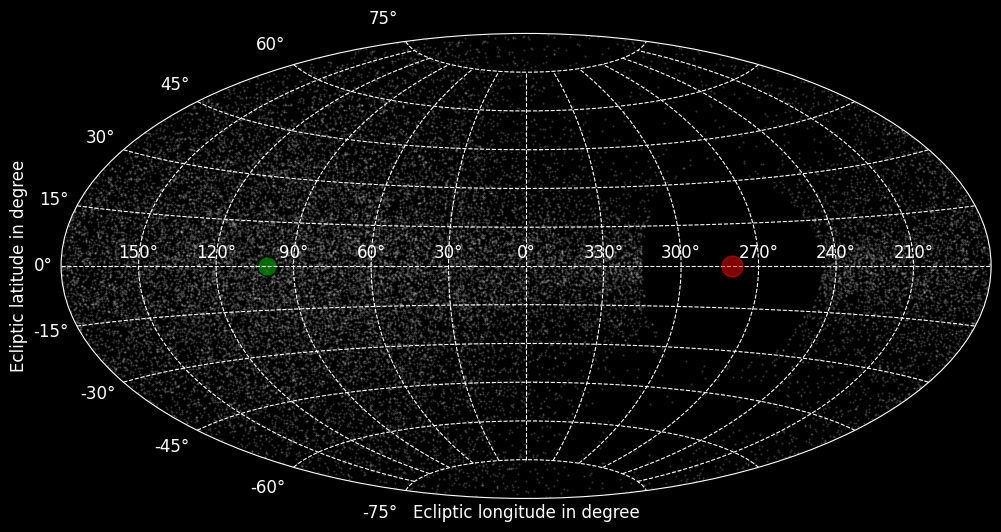

In [39]:
# Let's set a dark background
plt.style.use("dark_background")

# Set a default font size for better readability
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
ax = plt.subplot(projection="aitoff")
ax.grid(True, linestyle='--', color="white")

# Add the NEOs
plt.scatter(neo_positions_coord[:, 1],
            neo_positions_coord[:, 0],
            marker=".",
            s=1,
            alpha=0.2,
            color="white")

# Add the Sun
plt.plot(sun_ecl_long_4plot,
         sun_ecl_lat,
         color="red",
         marker="o",
         markersize=15,
         alpha=0.5)

# Add the Opposition point
plt.scatter(sun_opp_ecl_long_4plot,
            sun_opp_ecl_lat,
            color="green",
            marker="o",
            s=200,
            alpha=0.8,
            edgecolor='black')

plt.xlabel("Ecliptic longitude in degree")
plt.ylabel("Ecliptic latitude in degree")

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°'])

In [40]:
# We apply a broad kerne with a size of 5 degrees to smooth the resulting distribution
import sklearn.neighbors
kde = sklearn.neighbors.KernelDensity(bandwidth=np.radians(5),
                                      metric="haversine",
                                      kernel="exponential",
                                      algorithm="ball_tree")
kde.fit(neo_positions_coord)

KernelDensity(algorithm='ball_tree', bandwidth=np.float64(0.08726646259971647),
              kernel='exponential', metric='haversine')

In [41]:
# Compute the PDF in a long-lat mesh grid
sample_lat, sample_long = np.meshgrid(np.linspace(-0.5*np.pi, 0.5*np.pi, 100),
                                      np.linspace(-np.pi, np.pi, 100))
latlong = np.vstack([sample_lat.ravel(),
                     sample_long.ravel()]).T
sky_pdf = np.exp(kde.score_samples(latlong))
sky_pdf = sky_pdf.reshape(sample_lat.shape)

([<matplotlib.axis.XTick at 0x7220bb975520>,
 [Text(-2.6179938779914944, 0, '150°'),
  Text(-2.0943951023931953, 0, '120°'),
  Text(-1.5707963267948966, 0, '90°'),
  Text(-1.0471975511965976, 0, '60°'),
  Text(-0.5235987755982988, 0, '30°'),
  Text(0.0, 0, '0°'),
  Text(0.5235987755982988, 0, '330°'),
  Text(1.0471975511965976, 0, '300°'),
  Text(1.5707963267948966, 0, '270°'),
  Text(2.0943951023931953, 0, '240°'),
  Text(2.6179938779914944, 0, '210°')])

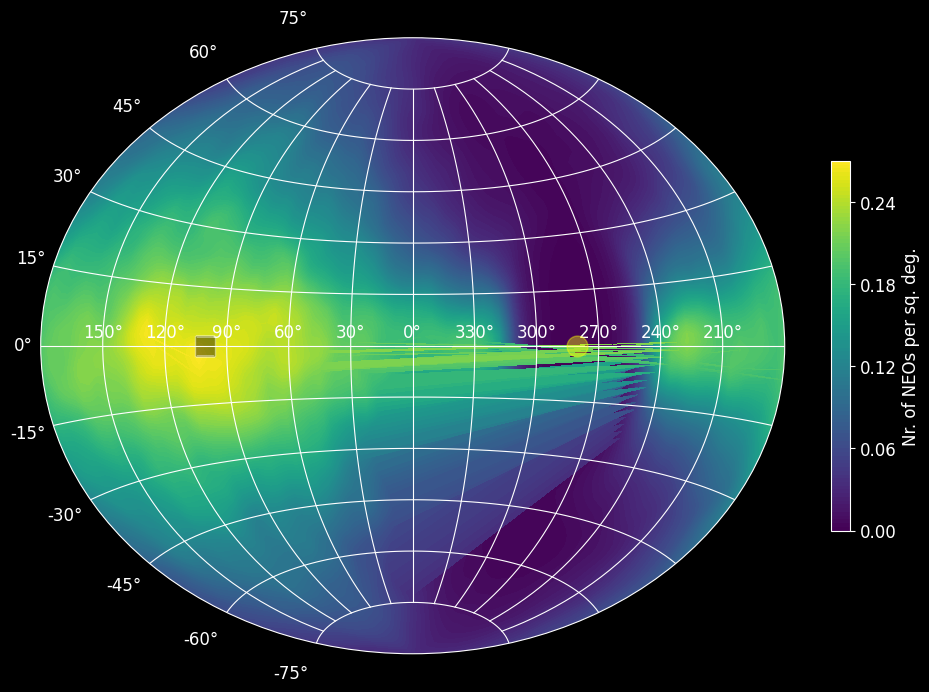

In [44]:
# pdf
neo_density = sky_pdf * len(neo_positions_coord)/(180/math.pi)**2 / 6

# Set a figure
plt.figure(figsize=(12, 8))

# # Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)


plt.imshow(neo_density, extent=(sample_long.min(), sample_long.max(), sample_lat.min(), sample_lat.max()), origin='lower', aspect='auto', interpolation='bilinear')

CS = plt.contourf(sample_long,
                  sample_lat,
                  neo_density,
                  levels=np.linspace(0, np.max(neo_density), 100),
                  antialiased=False)


cbar = plt.colorbar(CS, shrink=0.6)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label("Nr. of NEOs per sq. deg.")

# Add the Sun
plt.plot(sun_ecl_long_4plot,
         sun_ecl_lat,
         color="yellow",
         marker="o",
         markersize=15,
         alpha=0.4)

# Add the Opposition point
plt.scatter(sun_opp_ecl_long_4plot,
            sun_opp_ecl_lat,
            color="black",
            marker="s",
            s=200,
            alpha=0.4,
            edgecolor='white')

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])